In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from moabb.datasets import BI2013a

from power import field_root_mean_square, plot_fmrs
from data_processing import *

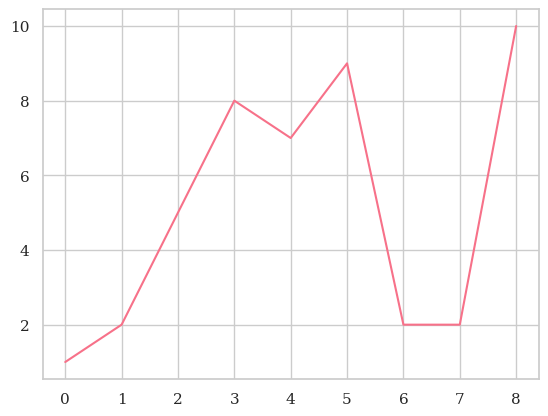

In [5]:
a = np.array([1,2,5,8,7,9,2,2,10])
plt.plot(a)

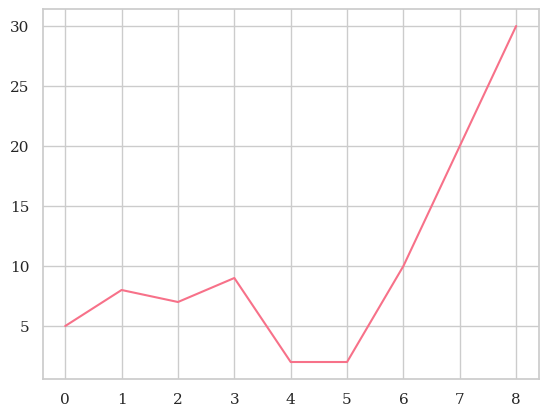

In [6]:
b = np.array([5,8,7,9,2,2,10,20,30])
plt.plot(b)

In [7]:
e_ = np.stack([np.expand_dims(a, axis=0), np.expand_dims(b, axis=0), np.expand_dims(a, axis=0)])
e_.shape, e_

((3, 1, 9),
 array([[[ 1,  2,  5,  8,  7,  9,  2,  2, 10]],
 
        [[ 5,  8,  7,  9,  2,  2, 10, 20, 30]],
 
        [[ 1,  2,  5,  8,  7,  9,  2,  2, 10]]]))

In [8]:
info_ = mne.create_info(1,9)
epochs_ = mne.EpochsArray(e_,info_)

Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated


len class_epochs_cropped 3
(3,)
[8. 7. 9.]
(3,)
[9. 2. 2.]
(3,)
[8. 7. 9.]
1
2
3
4
5
6


([0, 0, 0], [0, 0, 0, 0, 0, 0])

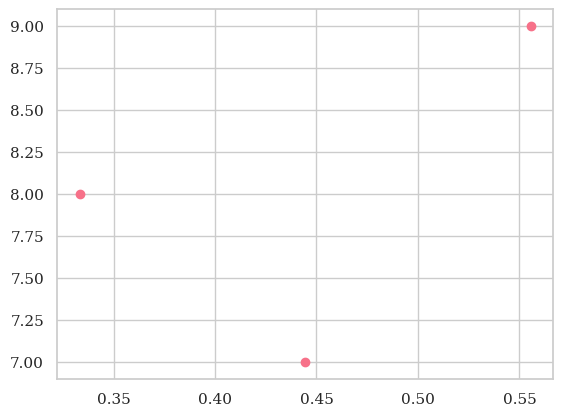

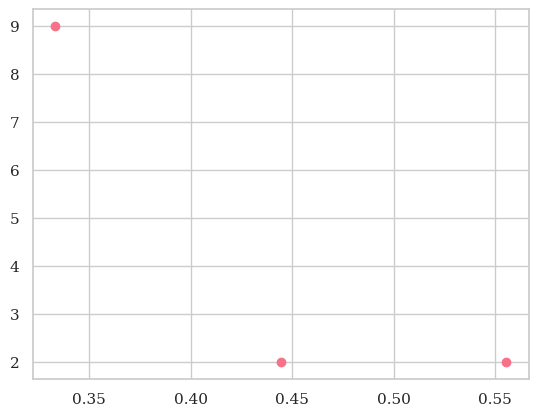

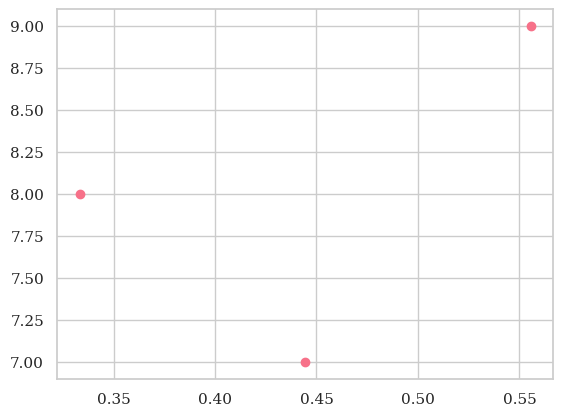

In [30]:
# lags_list, cond_hist
compute_lags(epochs_, similarity="covariance", criteria_sim="local_max")

In [12]:
lags_list, cond_hist

([2, -2, 2], [2, 2, 2, 2, 2, 2])

In [15]:
epochs_.get_data()

array([[[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]],

       [[ 5.,  8.,  7.,  9.,  2.,  2., 10., 20., 30.]],

       [[ 1.,  2.,  5.,  8.,  7.,  9.,  2.,  2., 10.]]])

In [14]:
E=3
class_epochs_cropped = copy.deepcopy(epochs_).crop(tmin=epochs_.times[E], tmax = epochs_.times[-E-1], include_tmax=True)
class_epochs_cropped.get_data()

array([[[8., 7., 9.]],

       [[9., 2., 2.]],

       [[8., 7., 9.]]])

In [17]:
epochs_idx = np.arange(len(class_epochs_cropped))
epochs_idx

array([0, 1, 2])

In [19]:
i=0
class_epochs_cropped[np.where(epochs_idx!= i)[0]].get_data()

array([[[9., 2., 2.]],

       [[8., 7., 9.]]])

In [20]:
avg_epochs_m1 = class_epochs_cropped[np.where(epochs_idx!= i)[0]].average(picks="all").get_data()
avg_epochs_m1

array([[8.5, 4.5, 5.5]])

In [21]:
lagged_e_is = lagged_epochs(epochs_[i],E)
for le_i in lagged_e_is:
    print(le_i.get_data())

[[[1. 2. 5.]]]
[[[2. 5. 8.]]]
[[[5. 8. 7.]]]
[[[8. 7. 9.]]]
[[[7. 9. 2.]]]
[[[9. 2. 2.]]]
[[[ 2.  2. 10.]]]


In [28]:
similarity = "covariance"

if similarity == "covariance":
    sim = np.array([(1/l_ei.get_data().shape[-1])*np.matrix.trace(l_ei.get_data()@avg_epochs_m1.T) for l_ei in lagged_e_is]).ravel()
if similarity == "correlation":
    sim = np.array([np.corrcoef(l_ei.get_data()[0], avg_epochs_m1)[0,1] for l_ei in lagged_e_is])

sim

array([15.        , 27.83333333, 39.        , 49.66666667, 37.        ,
       32.16666667, 27.        ])

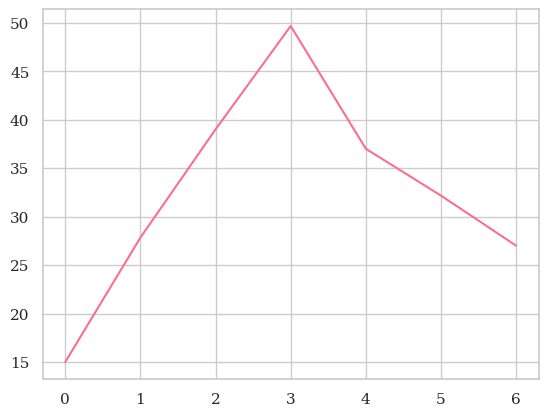

In [29]:
plt.plot(sim)

In [31]:
criteria_sim = "local_max"

if criteria_sim == "local_max":
    best_idx = find_local_max_idx(sim)
    print("local_max_idx: ", best_idx)
    if best_idx.size>0:
        best_idx = min(best_idx) #get smallest index (corresponds to the smallest lag)
    else:
        best_idx = E #if there is no local max that matches constraints, the lag is 0
if criteria_sim == "global_max":
    best_idx = np.argmax(sim) #if values are equal, by default takes the smallest argument

best_idx

local_max_idx:  [3]


3

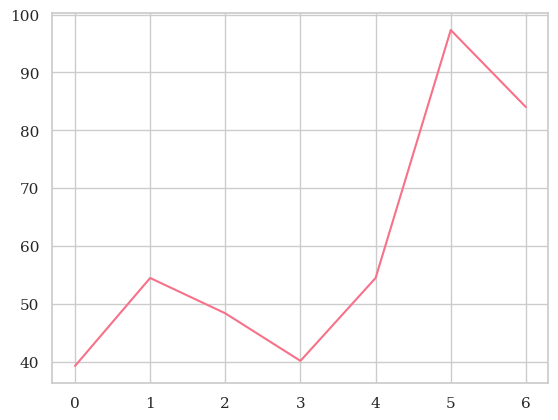

In [138]:
n_smooth=3
scovs = np.convolve(covs, np.ones(n_smooth)/n_smooth, mode='same')
plt.plot(scovs)

In [129]:
corrs = np.array([np.corrcoef(l_ei.get_data()[0], avg_epochs_m1)[0,1] for l_ei in lagged_e_is])
corrs

array([-0.32732684,  1.        , -0.97072534,  0.        ,  0.8660254 ,
        0.55441595,  0.5       ])

In [145]:
np.argmax([1,2,2,4,0,-1])

3

In [143]:
np.argmax(corrs)

1

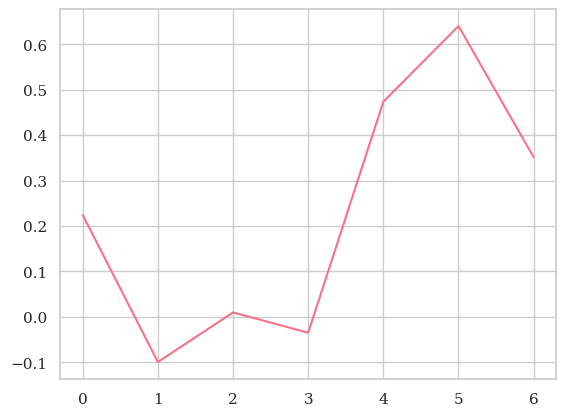

In [140]:
scorrs = np.convolve(corrs, np.ones(n_smooth)/n_smooth, mode='same')
plt.plot(scorrs)

In [130]:
lm_idx = find_local_max_idx(corrs)
lm_idx 

array([1, 4])

In [75]:
a = np.array([])
(a - E).size > 0

False

In [134]:
from scipy.signal import argrelextrema
smoothed_array = covs
max_idx = argrelextrema(smoothed_array, np.greater)[0]
max_idx

array([1])

In [135]:
valid_idx = np.where(smoothed_array>=0.50*np.max(smoothed_array))[0]
valid_idx

array([5, 6])

In [77]:
min(valid_idx[np.isin(valid_idx, max_idx)])

3

In [53]:
# valid_local_max_idx = np.flatnonzero(np.isin(max_idx, valid_idx))
# valid_local_max_idx

array([0])

len class_epochs_cropped 3
(3,)
[8. 7. 9.]
(3,)
[9. 2. 2.]
(3,)
[8. 7. 9.]
1
2
3
4
5
6


[0, 0, 0]

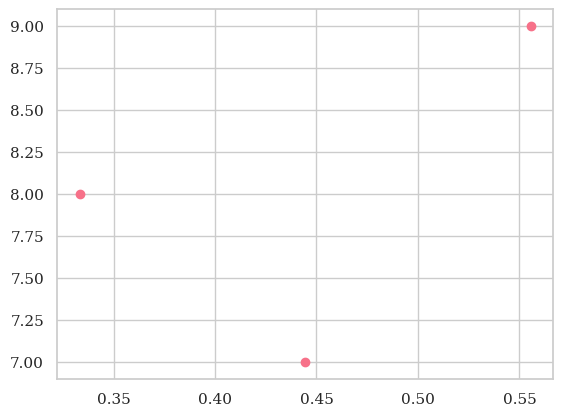

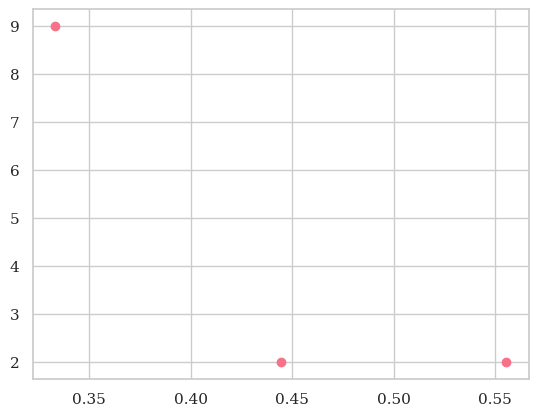

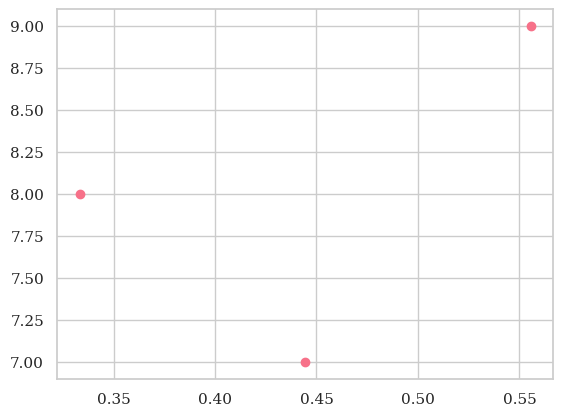

In [78]:
lags_list, cond_hist = compute_lags(epochs_)
lags_list

In [79]:
lags_list

[0, 0, 0]

In [ ]:
epochs_.times, epochs_.times[-E-1]

In [193]:
a = np.arange(10)
E = 2
for eps in range(2*E+1):
    print("eps", eps)
    print("-2*E+eps",len(a)+eps-2*E)
    print(a[eps: len(a)+eps-2*E])

eps 0
-2*E+eps 6
[0 1 2 3 4 5]
eps 1
-2*E+eps 7
[1 2 3 4 5 6]
eps 2
-2*E+eps 8
[2 3 4 5 6 7]
eps 3
-2*E+eps 9
[3 4 5 6 7 8]
eps 4
-2*E+eps 10
[4 5 6 7 8 9]


In [102]:
from scipy.signal import argrelextrema

smoothed_array = np.array([5,4,6,2])
max_idx = argrelextrema(smoothed_array, np.greater)
b = np.where(smoothed_array>=0.66%np.max(smoothed_array))
np.flatnonzero(np.isin(smoothed_array,[4,5]))

array([0, 1])

In [34]:
for e in (epochs_.iter_evoked()):
    print(type(e))

<class 'mne.evoked.EvokedArray'>
<class 'mne.evoked.EvokedArray'>
<class 'mne.evoked.EvokedArray'>


In [37]:
e.times

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889])

In [40]:
a = np.array([5,2,1,1,4])
# np.where()

In [44]:
a[2-1:-2-1]

array([2])

In [43]:
a[3:-1]

array([1])

In [ ]:
epochs_dummy = mne.EpochsArray(e_,info_)